In [1]:
import torch
import numpy as np
import os
import nltk
import torch.nn as nn
import torchvision.models as models
import warnings
warnings.filterwarnings('ignore') # make notebook more visible, disable warnings

from constants import config_data
from dataset_factory import get_datasets
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from model_factory import baseline_encoder, baseline_decoder, RNN_decoder


torch.manual_seed(128)
np.random.seed(seed = 100) # fix the random seed to make things reproducible

## Setup GPU(cuda)

In [2]:
#Setup GPU settings
print("GPU is availiable:", torch.cuda.is_available())
print("# of GPU:", torch.cuda.device_count())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Can run on GPU") 
else:
    device = torch.device("cpu")
    print("can only run on CPU")
    
print("Run on:", device)

GPU is availiable: True
# of GPU: 1
Can run on GPU
Run on: cuda:0


## Load the configration, and possibily adjust some of them

In [3]:
config_data['dataset']['batch_size'] = 20
config_data['dataset']['num_workers'] = 4

config_data

{'dataset': {'images_root_dir': 'data/images',
  'training_ids_file_path': 'data/train_ids.csv',
  'validation_ids_file_path': 'data/val_ids.csv',
  'test_ids_file_path': 'data/test_ids.csv',
  'training_annotation_file_path': 'data/annotations/captions_train2014.json',
  'test_annotation_file_path': 'data/annotations/captions_val2014.json',
  'vocabulary_threshold': 10,
  'img_size': (256, 256),
  'batch_size': 20,
  'num_workers': 4},
 'model': {'hidden_size': 512,
  'embedding_size': 300,
  'model_type': 'baseline'}}

## Get dataloaders

In [4]:
# get dataloaders 
coco_test, vocabulary, train_data_loader, val_data_loader, test_data_loader = get_datasets(config_data)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Using the saved vocab.
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


# Train

## Prepare model

In [5]:
vocab_size = len(vocabulary)
embed_size = config_data['model']['embedding_size']
hidden_size = config_data['model']['hidden_size']
vocab_size # see the vocab size for convininence to check dimensionalities

6336

In [6]:
# get the model
encoder = baseline_encoder(embed_size).to(device)
decoder = RNN_decoder(embed_size, hidden_size, vocab_size, device).to(device)

# get training ready
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters())+list(encoder.resnet.fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# specify the name of checkpoints
cp_name_encoder = "RNN_encoder.pt"
cp_name_decoder = "RNN_decoder.pt"

## Train and validation

In [7]:
train_loss = [] # used to record training loss per epoch
val_loss = [] # used to record validation loss per epoch
best_val_loss = float('inf') # used to record the best validation loss for saving the best model

for epoch in range(0, 10):
    # turn the train mode on
    encoder.train()
    decoder.train()
    
    # used to record losses per batch
    # average them as the loss per epoch after the epoch
    train_l_avg = [] 
    val_l_avg = []
    
    # go through the train set
    for batch_idx, (image, target, img_ids) in enumerate(train_data_loader):
        image, target = image.to(device), target.to(device) # set to GPU
        
        # zero gradients
        decoder.zero_grad()
        encoder.zero_grad()
        
        # get the image embedding
        feature = encoder(image)
        # pass the caption(target) and image embedding to the decoder
        output = decoder(feature, target)
        
        # gradient descendent
        loss = criterion(output.view(-1, vocab_size), target.view(-1))
        loss.backward()
        optimizer.step()
        
        train_l_avg.append(loss.item()) # record loss per batch
        
    # average loss per batch to get loss per epoch
    train_l = np.mean(train_l_avg) 
    train_loss.append(train_l)
    
    # turn the evaluation mode on
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): 
        # go through the validation set
        for batch_idx, (image, target, img_ids) in enumerate(val_data_loader):
            image, target = image.to(device), target.to(device) # set to GPU
            
            feature = encoder(image) # get the image embedding
            output = decoder(feature, target) # pass the caption(target) and image embedding to the decoder
            
            # get validation loss per batch
            loss = criterion(output.view(-1, vocab_size), target.view(-1))
            val_l_avg.append(loss.item())
            
    # average loss per batch to get loss per epoch
    val_l = np.mean(val_l_avg)
    val_loss.append(val_l)
    
    # if the validation loss is less, we have a better model
    if val_l < best_val_loss:
        best_val_loss = val_l
        torch.save(encoder.state_dict(), cp_name_encoder)
        torch.save(decoder.state_dict(), cp_name_decoder)
        
    #scheduler.step()
            
    print("Epoch", epoch + 1, "done:")
    print("training loss:", train_l)
    print("validation loss:", val_l, "\n")

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 1 done:
training loss: 2.4852910319281736
validation loss: 2.110612857341766 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 2 done:
training loss: 1.98581295492248
validation loss: 1.9021763792957167 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 3 done:
training loss: 1.8334901234180512
validation loss: 1.818529069567301 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 4 done:
training loss: 1.7389042731709348
validation loss: 1.7648761019649275 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 5 done:
training loss: 1.6695745408231144
validation loss: 1.7391193055244814 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 6 done:
training loss: 1.6190988936403785
validation loss: 1.7137981556984316 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 7 done:
training loss: 1.5726019538277303
validation loss: 1.6995387134781803 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 8 done:
training loss: 1.5399700567777974
validation loss: 1.6786977447659137 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 9 done:
training loss: 1.503178499852936
validation loss: 1.6709249785147517 



[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch 10 done:
training loss: 1.4728159517137749
validation loss: 1.6577706449003105 



## Train and validation loss plot

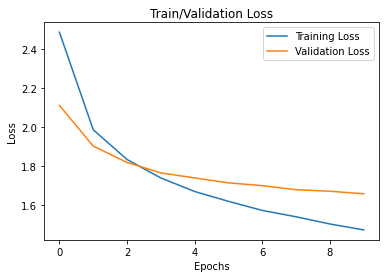

In [8]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])

# Evaluate by Test

In [7]:
from caption_utils import bleu1, bleu4 # provided functions to calculate scores

## Load the model

In [8]:
encoder = baseline_encoder(embed_size)
decoder = RNN_decoder(embed_size, hidden_size, vocab_size, device)

encoder.load_state_dict(torch.load(cp_name_encoder))
decoder.load_state_dict(torch.load(cp_name_decoder))

encoder = encoder.to(device)
decoder = decoder.to(device)

## Some functions helps us to evaluate BLEU scores

In [9]:
def caption2sentence(captions, vocabulary):
    """takes captions(list of word_idx) predicted by the model, and convert the captions to sentence(list of words)"""
    # get a batch of captions (word idx)
    
    out = []
    
    for i in range(len(captions)): # iterate through batch
        word_list = []
        
        for word_idx in captions[i]:
            word_list.append(vocabulary.idx2word[word_idx]) 
            
            if word_idx == 2: # if the word_idx == 2, <end>
                break
            
        word_list = word_list[1:-1] # discard <start> and <end>
        out.append(word_list)
        
    return out

In [10]:
def get_reference_caption(img_id, coco_test):
    """takes the img_id to get all captions(list of word_idx) of the image as reference to calcualte BLEU scores"""
    out = []
    for data in coco_test.imgToAnns[img_id]: # for each caption of given img_id
        # tokenize the captions to make it compatible with the BLEU scores
        caption_token = []
        ref_cap = data["caption"] 
        caption_tokenized = nltk.tokenize.word_tokenize(ref_cap.lower())
        out.append(caption_tokenized)
        
    return out

## Evaluate

In [13]:
# turn the evaluation mode on
encoder.eval()
decoder.eval()

test_l_avg = [] # used to calculate test loss, stores loss per batch
score1_avg = [] # used to calculate BLEU1, stores BLEU1 per batch
score4_avg = [] # used to calculate BLEU4, stores BLEU4 per batch

with torch.no_grad():
    # go through the test set
    for batch_idx, (image, target, img_ids) in enumerate(test_data_loader):
        image, target = image.to(device), target.to(device) # set to GPU
            
        # forward the model
        feature = encoder(image)
        output = decoder(feature, target)
            
        # get loss per batch
        loss = criterion(output.view(-1, vocab_size), target.view(-1))
        test_l_avg.append(loss.item())
        
        # predict according to the image embedding
        feat = feature.unsqueeze(1) # reshape to make it can be predicted by the model
        predicted_captions = decoder.predict(feat,deterministic=True, temp=1.0)
        # convert predictions(list of word_idx) into sentence(list of words)
        predicted_captions = caption2sentence(predicted_captions, vocabulary)
        
        for i in range(len(predicted_captions)): # go through each element in the batch
            predicted = predicted_captions[i]
            im_id = img_ids[i] # get the img_id of the image
            reference = get_reference_caption(im_id, coco_test) # get reference for the image
            
            # get scores
            score1 = bleu1(reference, predicted)
            score4 = bleu4(reference, predicted)
            
            # print some examples to make sure everything goes alright
            if i == 0 and batch_idx== 0:
                print("predicted", predicted)
                print("reference", reference)
                print("bleu1:", score1)
                print("bleu4:", score4, "\n")
        
            # record scores per element
            score1_avg.append(score1)
            score4_avg.append(score4)
        
print("Test loss is:", np.mean(test_l_avg)) # test loss by averaging loss per batch
# scores get by averaging scores of all images
print("BLEU1 is:", np.mean(score1_avg))
print("BLEU4 is:", np.mean(score4_avg))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


predicted ['a', 'bathroom', 'with', 'a', 'toilet', ',', 'sink', ',', 'and', 'mirror', '.']
reference [['a', 'cat', 'standing', 'next', 'to', 'a', 'white', 'toilet', 'near', 'a', 'bath', 'tub', '.'], ['a', 'cat', 'in', 'a', 'bathroom', 'with', 'a', 'tub', 'and', 'a', 'toilet', '.'], ['a', 'white', 'toilet', 'and', 'a', 'bath', 'in', 'a', 'room', '.'], ['a', 'toilet', 'and', 'a', 'bathtub', 'in', 'a', 'bathroom', 'with', 'a', 'cat', 'next', 'to', 'it'], ['a', 'bathroom', 'with', 'a', 'toilet', ',', 'bathtub', ',', 'and', 'a', 'cat', 'in', 'a', 'bathroom', '.']]
bleu1: 81.81818181818183
bleu4: 37.5 

Test loss is: 1.6706592441398833
BLEU1 is: 66.21902643466406
BLEU4 is: 7.811973185878908


# Generate Examples

In [11]:
import skimage.io as io

In [14]:
def get_example(img_id, coco_test,reference,pred, good, temperature):
    img = coco_test.loadImgs(im_id)[0]
    I = io.imread("./data/images/test" + '/' + img['file_name'])
    plt.axis('off')
    plt.title("RNN_example_" + temperature + "_" + good)
    txt="Predicted caption: " + " ".join(pred)
    plt.figtext(0.1,0 , txt,wrap=True)
    txt = "Actural caption: "
    plt.figtext(0.1,-0.1, txt,wrap=True)
    dis = -0.2
    for i in range(len(reference)):
        txt = " ".join(reference[i])
        plt.figtext(0.1,dis , txt,wrap=True)
        dis -= 0.1
    plt.imshow(I)
    dirt = "./example/RNN/"
    plt.savefig(dirt+str(im_id)+"_"+"RNN_"+good+".jpg",bbox_inches="tight")
    plt.show()
    
    
    return

## 0.4 Temperature

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


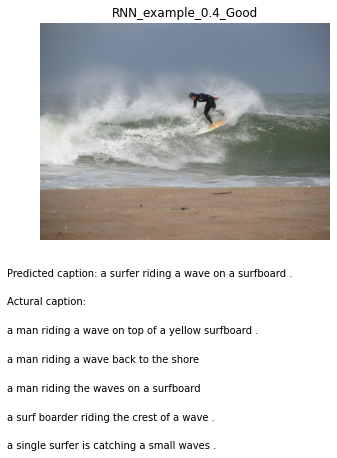

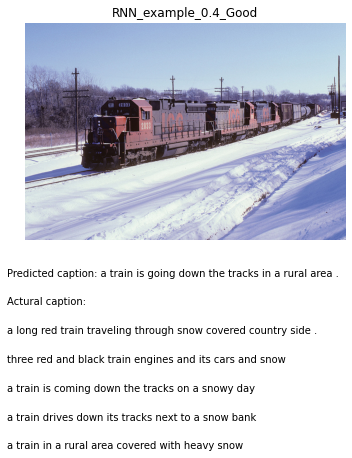

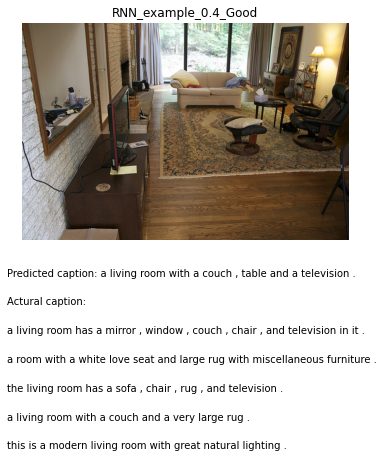

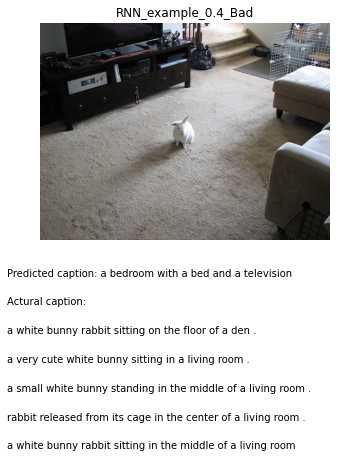

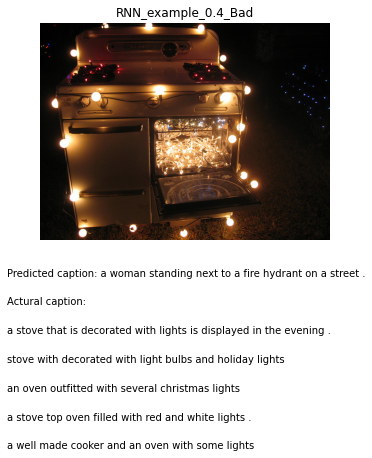

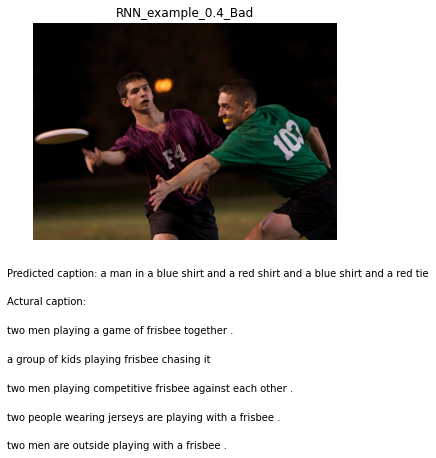

In [16]:
# turn the evaluation mode on
encoder.eval()
decoder.eval()

good = 0
bad = 0
with torch.no_grad():
    # go through the test set
    for batch_idx, (image, target, img_ids) in enumerate(test_data_loader):
        image, target = image.to(device), target.to(device) # set to GPU
            
        # forward the model
        feature = encoder(image)
        output = decoder(feature, target)
        
        # predict according to the image embedding
        feat = feature.unsqueeze(1) # reshape to make it can be predicted by the model
        predicted_captions = decoder.predict(feat,deterministic=False, temp=0.4)
        # convert predictions(list of word_idx) into sentence(list of words)
        predicted_captions = caption2sentence(predicted_captions, vocabulary)
        
        
        for i in range(len(predicted_captions)): # go through each element in the batch
            predicted = predicted_captions[i]
            im_id = img_ids[i] # get the img_id of the image
            reference = get_reference_caption(im_id, coco_test) # get reference for the image
            
            # get scores
            score1 = bleu1(reference, predicted)
            score4 = bleu4(reference, predicted)
            
            if score1 < 20 and bad < 3:
                get_example(im_id,coco_test,reference,predicted,"Bad", "0.4")
                bad += 1
            if score1 > 90 and good < 3:
                get_example(im_id,coco_test,reference,predicted,"Good", "0.4")
                good += 1
                
        if good >= 3 and bad >= 3:
                break

## Deterministic

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


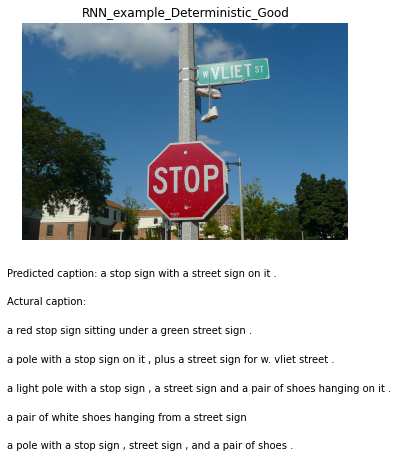

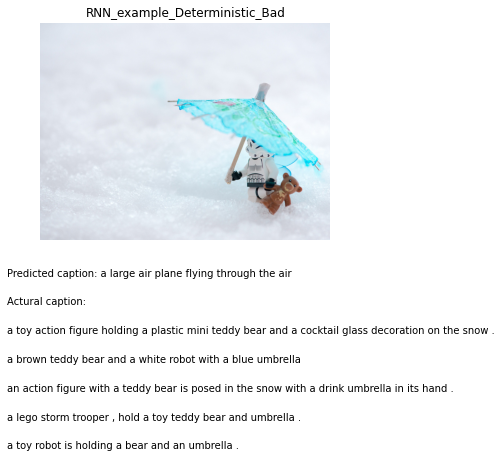

In [24]:
# turn the evaluation mode on
encoder.eval()
decoder.eval()

good = 0
bad = 0
with torch.no_grad():
    # go through the test set
    for batch_idx, (image, target, img_ids) in enumerate(test_data_loader):
        image, target = image.to(device), target.to(device) # set to GPU
            
        # forward the model
        feature = encoder(image)
        output = decoder(feature, target)
        
        # predict according to the image embedding
        feat = feature.unsqueeze(1) # reshape to make it can be predicted by the model
        predicted_captions = decoder.predict(feat,deterministic=True)
        # convert predictions(list of word_idx) into sentence(list of words)
        predicted_captions = caption2sentence(predicted_captions, vocabulary)
        
        
        for i in range(len(predicted_captions)): # go through each element in the batch
            predicted = predicted_captions[i]
            im_id = img_ids[i] # get the img_id of the image
            reference = get_reference_caption(im_id, coco_test) # get reference for the image
            
            # get scores
            score1 = bleu1(reference, predicted)
            score4 = bleu4(reference, predicted)
            
            if score1 < 20 and bad < 1:
                get_example(im_id,coco_test,reference,predicted,"Bad", "Deterministic")
                bad += 1
            if score1 > 90 and good < 1:
                get_example(im_id,coco_test,reference,predicted,"Good", "Deterministic")
                good += 1
                
        if good >= 1 and bad >= 1:
                break

## Large Temperature

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


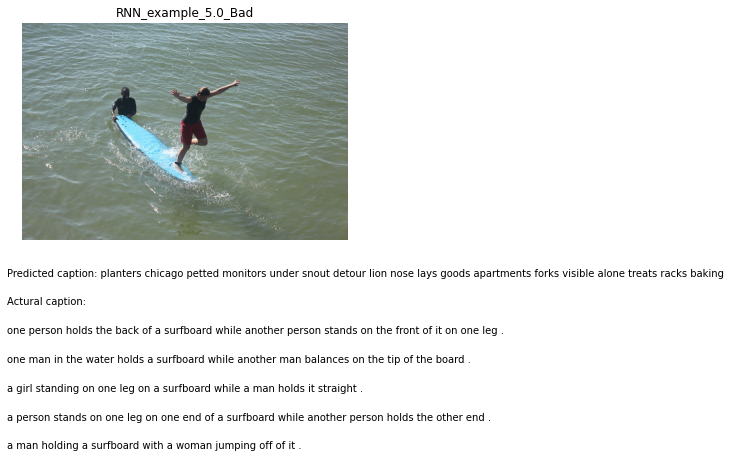

In [18]:
# turn the evaluation mode on
encoder.eval()
decoder.eval()

good = 0
bad = 0
with torch.no_grad():
    # go through the test set
    for batch_idx, (image, target, img_ids) in enumerate(test_data_loader):
        image, target = image.to(device), target.to(device) # set to GPU
            
        # forward the model
        feature = encoder(image)
        output = decoder(feature, target)
        
        # predict according to the image embedding
        feat = feature.unsqueeze(1) # reshape to make it can be predicted by the model
        predicted_captions = decoder.predict(feat,deterministic=False, temp=5.0)
        # convert predictions(list of word_idx) into sentence(list of words)
        predicted_captions = caption2sentence(predicted_captions, vocabulary)
        
        
        for i in range(len(predicted_captions)): # go through each element in the batch
            predicted = predicted_captions[i]
            im_id = img_ids[i] # get the img_id of the image
            reference = get_reference_caption(im_id, coco_test) # get reference for the image
            
            # get scores
            score1 = bleu1(reference, predicted)
            score4 = bleu4(reference, predicted)
            
            if score1 < 20 and bad < 1:
                get_example(im_id,coco_test,reference,predicted,"Bad", "5.0")
                bad += 1
            if score1 > 90 and good < 1:
                get_example(im_id,coco_test,reference,predicted,"Good", "5.0")
                good += 1
                
        if good >= 1 and bad >= 1:
                break

## Low Temperature

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


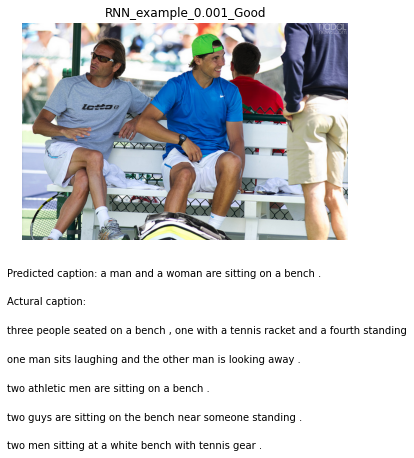

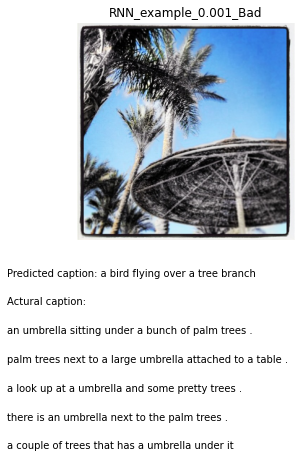

In [30]:
# turn the evaluation mode on
encoder.eval()
decoder.eval()

good = 0
bad = 0
with torch.no_grad():
    # go through the test set
    for batch_idx, (image, target, img_ids) in enumerate(test_data_loader):
        image, target = image.to(device), target.to(device) # set to GPU
            
        # forward the model
        feature = encoder(image)
        output = decoder(feature, target)
        
        # predict according to the image embedding
        feat = feature.unsqueeze(1) # reshape to make it can be predicted by the model
        predicted_captions = decoder.predict(feat,deterministic=False, temp=0.001)
        # convert predictions(list of word_idx) into sentence(list of words)
        predicted_captions = caption2sentence(predicted_captions, vocabulary)
        
        
        for i in range(len(predicted_captions)): # go through each element in the batch
            predicted = predicted_captions[i]
            im_id = img_ids[i] # get the img_id of the image
            reference = get_reference_caption(im_id, coco_test) # get reference for the image
            
            # get scores
            score1 = bleu1(reference, predicted)
            score4 = bleu4(reference, predicted)
            
            if score1 < 20 and bad < 1:
                get_example(im_id,coco_test,reference,predicted,"Bad", "0.001")
                bad += 1
            if score1 > 90 and good < 1:
                get_example(im_id,coco_test,reference,predicted,"Good", "0.001")
                good += 1
                
        if good >= 1 and bad >= 1:
                break